<a href="https://colab.research.google.com/github/jmellafe/question_deduplication/blob/master/merge_alex_hend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, KeyedVectors
from collections import Counter
from nltk.corpus import stopwords

from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

pd.options.mode.chained_assignment = None # To avoid warnings

In [2]:
# import data from the drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv' #change dir to your project folder

Mounted at /content/gdrive


# 0. Exploring the dataset



In [8]:
# Hend data importing cell 

df = pd.read_csv('/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv')
df.head()

FileNotFoundError: ignored

In [3]:
#Alex data importing cell

df = pd.read_csv('/content/gdrive/My Drive/project/data/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# Shuffle the data

df = df.sample(frac=1, random_state = 0).reset_index(drop=True)

# Create train, validation and test datasets
train_portion = 0.7
val_portion = 0.15
test_portion = 0.15

train_idx = int(train_portion * df.shape[0])
val_idx = int((train_portion + val_portion) * df.shape[0])

train = df[:train_idx]
val = df[train_idx:val_idx]
test = df[val_idx:]

Class 0:  178510  Class1:  104493


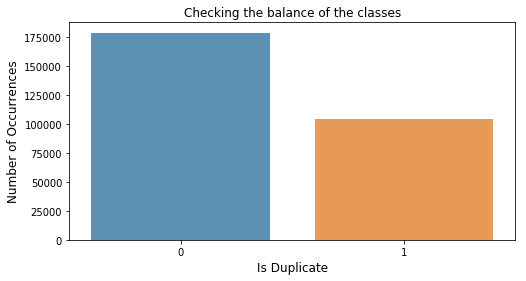

In [5]:
is_dup = train['is_duplicate'].value_counts()
print("Class 0: ", is_dup[0], " Class1: ", is_dup[1])
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.title('Checking the balance of the classes')
plt.show()

In [0]:
# balancing the training set
class0 = train[train['is_duplicate']==0].sample(n=is_dup[1], random_state=1)
class1 = train[train['is_duplicate']==1]
train = pd.concat([class0, class1])

train = train.sample(frac = 1).reset_index(drop = True)

No handles with labels found to put in legend.


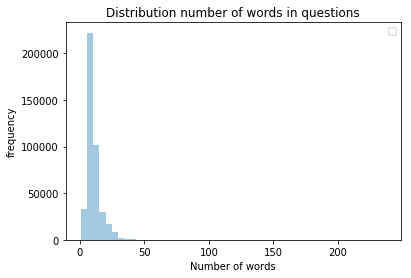

<Figure size 432x288 with 0 Axes>

In [0]:

# HIstogram number of words

temp = train['question1'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp2 = train['question2'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp = pd.concat([temp, temp2]).dropna()

sns.distplot(temp, kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()


No handles with labels found to put in legend.


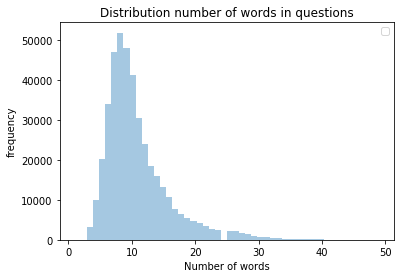

<Figure size 432x288 with 0 Axes>

In [0]:
# detail same plot
sns.distplot(temp[temp < 50], kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()

# 1.Random Forest

see papers: http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/proceedings/p1221.pdf 


In [0]:
# Embedding file, Alex path
EMBEDDING_FILE = '/content/gdrive/My Drive/project/embeddings/GoogleNews-vectors-negative300.bin'

In [0]:
# Embbeding file, Hend path
EMBEDDING_FILE = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/GoogleNews-vectors-negative300.bin.gz'

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Tokenization of datasets
train['q1_tokens'] = train['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
train['q2_tokens'] = train['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

val['q1_tokens'] = val['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
val['q2_tokens'] = val['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

test['q1_tokens'] = test['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
test['q2_tokens'] = test['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

In [10]:
# delete stopwords
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))
train['q1_tokens'] = train['q1_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)
train['q2_tokens'] = train['q2_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)

val['q1_tokens'] = val['q1_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)
val['q2_tokens'] = val['q2_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)

test['q1_tokens'] = test['q1_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)
test['q2_tokens'] = test['q2_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS] if isinstance(x, list) else x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Create gensim dictionary to allow BoW representation
dctr = Dictionary(train['q1_tokens'].dropna())
dctr.add_documents(train['q2_tokens'].dropna())

# Create tf-idf model
corpus = train['q1_tokens'].tolist() + train['q2_tokens'].tolist()
corpus = [dctr.doc2bow(sent) for sent in corpus if type(sent)==list]
model = TfidfModel(corpus)

# Apply tf-idf to all the questions in the training set, creating new columns
train['q1_tfidf'] = train['q1_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)
train['q2_tfidf'] = train['q2_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)

val['q1_tfidf'] = val['q1_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)
val['q2_tfidf'] = val['q2_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)

test['q1_tfidf'] = test['q1_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)
test['q2_tfidf'] = test['q2_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)

train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_tokens,q2_tokens,q1_tfidf,q2_tfidf
0,282133,202489,22665,Which is the most used programming language in...,Which computer language is the most used?,1,"[Which, used, programming, language, world, cu...","[Which, computer, language, used, ?]","[(0, 8.939333220814905e-05), (1, 0.25172827630...","[(0, 0.00011748551739742082), (1, 0.3308348179..."
1,339444,467106,52236,What inspires you the most in your life?,What inspires you most to do something in your...,0,"[What, inspires, life, ?]","[What, inspires, something, life, ?]","[(0, 0.00010188545055962743), (7, 0.0918185888...","[(0, 8.923360106546234e-05), (7, 0.08041681396..."
2,97747,162580,162581,Is it that tough to get into IIT?,Is it tough to get into IIT?,1,"[Is, tough, get, IIT, ?]","[Is, tough, get, IIT, ?]","[(0, 9.687800669647881e-05), (10, 0.5666653365...","[(0, 9.687800669647881e-05), (10, 0.5666653365..."
3,26633,49539,49540,What practical applications might evolve from ...,Are there any practical applications for the d...,1,"[What, practical, applications, might, evolve,...","[Are, practical, applications, discovery, Higg...","[(0, 4.940339845879814e-05), (7, 0.04452206182...","[(0, 5.377422683391227e-05), (15, 0.4594452729..."
4,283052,86534,403086,What has been the single most important life d...,What is the biggest/most important decision yo...,1,"[What, single, important, life, decision, made...","[What, biggest/most, important, decision, took...","[(0, 7.353793438842072e-05), (7, 0.06627196838...","[(0, 4.846161191254096e-05), (7, 0.04367332913..."


In [0]:
# Create question embeddings as the weighted average of word2vec embeddings, using tfidf for weighting

# Load embeddings

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


def tfidf_emb(tfidf_weights, dctr, embeddings):
  return np.mean([w[1] * embeddings[dctr[w[0]]] for w in tfidf_weights if dctr[w[0]] in embeddings.vocab], axis = 0) if isinstance(tfidf_weights, list) else np.nan

train['q1_emb'] = train['q1_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))
train['q2_emb'] = train['q2_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))

val['q1_emb'] = val['q1_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))
val['q2_emb'] = val['q2_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))

test['q1_emb'] = test['q1_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))
test['q2_emb'] = test['q2_tfidf'].apply(lambda x: tfidf_emb(x, dctr, word2vec))

word2vec = None

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [0]:
# preparing the features 


#series of all the questions in the training set 
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
print("Question: ",train_qs[1])

#length of the questions provided in the train set
len_qs_train = train_qs.apply(lambda x: len(x.split(' ')))
print("lengh of the question: ",len_qs_train[1])

qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
print("The pourcentage of questions including '?' : ",qmarks)

fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
print("The pourcentage of questions including '.' : ",fullstop)

capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
print("The pourcentage of questions starting with a capital letter is: ",capital_first)

capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
print("The pourcentage of questions including capital letters : ",capitals)

numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))
print("The mean max numbers of digits in  of questions including numbers : ",numbers)

Question:  What inspires you the most in your life?
lengh of the question:  8
The pourcentage of questions including '?' :  0.9988994478099011
The pourcentage of questions including '.' :  0.05602049898079297
The pourcentage of questions starting with a capital letter is:  0.9983228541624798
The pourcentage of questions including capital letters :  0.9995502091049161
The mean max numbers of digits in  of questions including numbers :  0.11622070377920052


In [0]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=1):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = [item for sentence in (train['q1_tokens'].dropna().tolist() + train['q2_tokens'].dropna().tolist()) for item in sentence]
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words('english'))

In [0]:
def sim_tfidf(a, b):
  if not isinstance(a, list) or not isinstance(b, list) or len(a) + len(b) == 0:
    return np.nan
  
  max_idx = max([w[0] for w in a] + [w[0] for w in b])+1
  
  a_vec = np.zeros(max_idx)
  b_vec = np.zeros(max_idx)
  
  for w in a:
    a_vec[w[0]] = w[-1]
    
  for w in b:
    b_vec[w[0]] = w[-1]
  return cosine_similarity(a_vec.reshape(1,-1),b_vec.reshape(1,-1))[0][0]


def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    
    return R


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

  
def sim_emb(q1_emb, q2_emb):
  
  if type(q1_emb) != np.ndarray or type(q2_emb) != np.ndarray:
    return np.nan
  
  return cosine_similarity(q1_emb.reshape(1,-1), q2_emb.reshape(1,-1))[0][0]

  
  
  
  
train_word_match = train.apply(word_match_share, axis=1, raw=True)

tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)

tfidf_similarity = train.apply(lambda row: sim_tfidf(row['q1_tfidf'], row['q2_tfidf']), axis=1, raw=True)

emb_similarity = train.apply(lambda row: sim_emb(row['q1_emb'], row['q2_emb']), axis=1, raw=True)


x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_train['tfidf_similarity'] = tfidf_similarity
x_train['emb_similarity'] = emb_similarity
x_train['q1_emb'] = train['q1_emb']
x_train['q2_emb'] = train['q2_emb']
x_train['id'] = train['id']
x_train['is_duplicate'] = train['is_duplicate']

x_train = x_train.dropna().reset_index(drop = True)

y_train = x_train['is_duplicate'].values




val_word_match = val.apply(word_match_share, axis=1, raw=True)
tfidf_val_word_match = val.apply(tfidf_word_match_share, axis=1, raw=True)
tfidf_val_similarity = val.apply(lambda row: sim_tfidf(row['q1_tfidf'], row['q2_tfidf']), axis=1, raw=True)

emb_val_similarity = val.apply(lambda row: sim_emb(row['q1_emb'], row['q2_emb']), axis=1, raw=True)


x_val = pd.DataFrame()
x_val['word_match'] = val_word_match
x_val['tfidf_word_match'] = tfidf_val_word_match
x_val['tfidf_similarity'] = tfidf_val_similarity
x_val['emb_similarity'] = emb_val_similarity
x_val['q1_emb'] = val['q1_emb']
x_val['q2_emb'] = val['q2_emb']
x_val['is_duplicate'] = val['is_duplicate']
x_val = x_val.dropna().reset_index(drop = True)

y_val = x_val['is_duplicate'].values

x_val['id'] = val['id']

predictors=['word_match','tfidf_word_match', 'tfidf_similarity', 'emb_similarity']
target='is_duplicate'


X_train= x_train[predictors]
y_train = x_train[target]
X_val = x_val[predictors]
#y_test = x_test[target]

#X=np.array(X).reshape(-1,1)
#y=np.array(y).reshape(-1,1)
#X= X.tolist()
#y= y.tolist()


def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal


clf= RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=100, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=1, verbose=0, warm_start=False, class_weight=None)
clf.fit(X_train,y_train)
##
accuracy=clf.score(X_val,y_val)
print("Random Forest",accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


Random Forest 0.743886252778976


NameError: ignored

# 2. Siamese network 
https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18

## 2.1 Importing libraries and data

In [14]:
# importing libraries 

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

# File paths
TRAIN_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv'
TEST_CSV = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/test.csv'
EMBEDDING_FILE = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/Models/malstm_trained.h5'

# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
#test_df = pd.read_csv(TRAIN_CSV)
test_df = train_df[:1000]

stops = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


FileNotFoundError: ignored

In [0]:
# Create embedding matrix

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #delete special characters
    text = re.sub(r"what's", "what is ", text) # replace what's by what is
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec


In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)


In [0]:
# Build the model


# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 100 # prevously 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))



malstm_trained.save(MODEL_SAVING_DIR)  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model




In [0]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [0]:
# Plotting the results


# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



# 3. GRU Deep Model

Inspired by this Network Architecture

https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur/

In [11]:
# Create embedding matrix

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text) #delete special characters
    text = re.sub(r"what's", "what is ", text) # replace what's by what is
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['q1_tokens', 'q2_tokens']

# Iterate over the questions only of both training and test datasets
for dataset in [train, val, test]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:
          
            if type(row[question]) != float:

              for word in row[question]:

                  # Check for unwanted words
                  if word not in word2vec.vocab:
                      continue

                  if word not in vocabulary:
                      vocabulary[word] = len(inverse_vocabulary)
                      inverse_vocabulary.append(word)
            # Replace questions as word to question as number representation
              q2n = [vocabulary[w] for w in row[question] if w in vocabulary]
            else:
              q2n = []
              
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
# create training and validation set for keras model

max_seq_length = max(train.q1_tokens.map(lambda x: len(x)).max(),
                     train.q2_tokens.map(lambda x: len(x)).max(),
                     val.q1_tokens.map(lambda x: len(x)).max(),
                     val.q2_tokens.map(lambda x: len(x)).max())


X_train = train[questions_cols]
Y_train = train['is_duplicate']

X_validation = val[questions_cols]
Y_validation = val['is_duplicate']

# Split to dicts
X_train = {'left': X_train.q1_tokens, 'right': X_train.q2_tokens}
X_validation = {'left': X_validation.q1_tokens, 'right': X_validation.q2_tokens}
# X_test = {'left': test.q1_tokens, 'right': test.q2_tokens}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense
from keras.layers import Dropout, Flatten, Embedding
import keras


def define_network(embeddings, max_seq_length):


    input_1 = Input((max_seq_length,), dtype = 'int32', name = 'q1_input') # Input question 1
    input_2 = Input((max_seq_length,), dtype = 'int32', name = 'q2_input') # Input question 2

    embedding_layer = Embedding(len(embeddings), 300, weights=[embeddings], input_length=max_seq_length, trainable=False)
    
    embd_1 = embedding_layer(input_1)
    embd_2 = embedding_layer(input_2)
    
    gru_shared_layer = GRU(300, dropout = 0.2, recurrent_dropout = 0.2, name = 'GRU_common')
    gru_1 = gru_shared_layer(embd_1)
    gru_2 = gru_shared_layer(embd_2)

    merge = keras.layers.merge.concatenate([gru_1, gru_2])
    
    bn = BatchNormalization()(merge)
    dense = Dense(300, activation = 'relu', name = "relu_dense")(bn)
    drop = Dropout(0.2)(dense)
    bn2 = BatchNormalization()(drop)
    output = Dense(1, activation = 'sigmoid', name = 'output_dense')(bn2)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [0]:
batch_size = 64
n_epoch = 20

In [0]:
model = define_network(embeddings, max_seq_length)

history = model.fit([X_train['left'], X_train['right']], Y_train, batch_size = batch_size,
                    epochs = n_epoch, validation_data = ([X_validation['right'], X_validation['left']], Y_validation))

model.save('model_alex.h5')

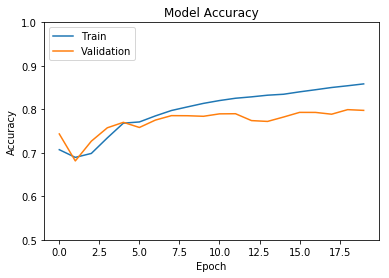

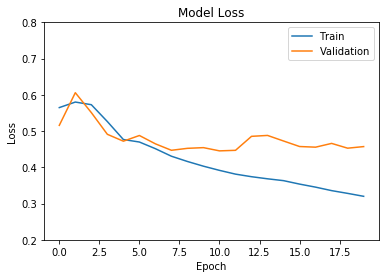

In [5]:
# analysis results + plots
epoch_array = np.arange(20)
hist = np.array([
[0.5648, 0.7072, 0.5158, 0.7434],
[0.5801, 0.6895, 0.6059, 0.6814],
[0.5728, 0.6986, 0.5510, 0.7268],
[0.5263, 0.7344, 0.4911, 0.7576],
[0.4767, 0.7682, 0.4721, 0.7701],
[0.4698, 0.7710, 0.4878, 0.7583],
[0.4514, 0.7849, 0.4648, 0.7753],
[0.4306, 0.7973, 0.4470, 0.7855],
[0.4161, 0.8056, 0.4524, 0.7853],
[0.4031, 0.8137, 0.4543, 0.7840],
[0.3916, 0.8202, 0.4454, 0.7896],
[0.3812, 0.8255, 0.4469, 0.7899],
[0.3741, 0.8287, 0.4855, 0.7741],
[0.3683, 0.8325, 0.4880, 0.7722],
[0.3632, 0.8347, 0.4726, 0.7823],
[0.3537, 0.8402, 0.4574, 0.7930],
[0.3453, 0.8451, 0.4556, 0.7929],
[0.3357, 0.8502, 0.4660, 0.7888],
[0.3281, 0.8542, 0.4528, 0.7993],
[0.3200, 0.8585, 0.4572, 0.7976]
]) # Extracted from Google Cloud Logs




# Plot accuracy
plt.plot(epoch_array, hist[:, 1])
plt.plot(epoch_array, hist[:, -1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5,1])
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(epoch_array, hist[:, 0])
plt.plot(epoch_array, hist[:, 2])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0.2,0.8])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
import itertools
# create training and validation set for keras model

max_seq_length = max(train.q1_tokens.map(lambda x: len(x)).max(),
                     train.q2_tokens.map(lambda x: len(x)).max(),
                     val.q1_tokens.map(lambda x: len(x)).max(),
                     val.q2_tokens.map(lambda x: len(x)).max())

questions_cols = ['q1_tokens', 'q2_tokens']
X_val = val[questions_cols]
Y_val = val['is_duplicate']

# Split to dicts
X_val = {'left': X_val.q1_tokens, 'right': X_val.q2_tokens}

# Convert labels to their numpy representations
Y_val = Y_val.values
# Zero padding
for dataset, side in itertools.product([X_val], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_val['left'].shape == X_val['right'].shape
assert len(X_val['left']) == len(Y_val)

In [45]:
# Performance in test set
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
# load model
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('/content/gdrive/My Drive/project/Models/my_model.h5')

NameError: ignored

In [42]:
y_preds = model.predict([X_test['left'],X_test['right']], verbose = 1)

42848/60644 [====================>.........] - ETA: 8:52

KeyboardInterrupt: ignored

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Function from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    

y_pred_hard = np.zeros(y_preds.shape[0])
y_pred_hard[y_preds[:, 0] >= 0.5] = 1
cnf_matrix = confusion_matrix(Y_val,y_pred_hard)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=[0,1])


print("Test Accuracy = %.6f"%accuracy_score(Y_val, y_pred_hard))

In [0]:
X_test['left'].shape

In [36]:
c1 = X_test[]

array([1, 0, 1, ..., 1, 1, 0])